In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi

assets_dir = '../Assets/template_matching/'

In [15]:
train_images=[
    cv2.imread(assets_dir+'circle.jpg',0),
    cv2.imread(assets_dir+'star_2.jpg',0),
    cv2.imread(assets_dir+'hexa.jpg',0)
]

test_images=[
    cv2.imread(assets_dir+'circle_2.jpg',0),
    cv2.imread(assets_dir+'star.jpg',0),
    cv2.imread(assets_dir+'triangle.jpg',0),
    cv2.imread(assets_dir+'circle.jpg',0)
]

In [20]:
def obj_geometry(bin_img):
    area = np.count_nonzero(bin_img)

    e_kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(bin_img, e_kernel, iterations=1)
    border_img = bin_img - eroded
    perimeter = np.count_nonzero(border_img)

    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key = cv2.contourArea)
    if len(cnt) >= 5:
        (x, y),(MA, ma), angle = cv2.fitEllipse(cnt)

    a = max(MA, ma)
    b = min(MA, ma)
    
    return area, perimeter, (a, b)

In [21]:
def descriptors(binary_img):
    area, perimeter, (a, b) = obj_geometry(binary_img)

    compactness = (perimeter**2) / area
    form_factor = (4 * pi * area) / (perimeter**2)
    eccentricity = sqrt(1 - (b/a)**2)

    return form_factor, compactness, eccentricity

In [22]:
def kl_divergence(p,q):
    p = np.array(p)
    q = np.array(q)
    p = p/sum(p)
    q = q/sum(q)

    return sum(p*np.log(p/q))

In [28]:
train_descriptors=[]
test_descriptors=[]

for i,img in enumerate(train_images):
    form, comp, ecc = descriptors(img)
    train_descriptors.append((form, comp, ecc))

for i, img in enumerate(test_images):
    form, comp, ecc = descriptors(img)
    test_descriptors.append((form, comp, ecc))

distances_matrix = []
for i, test_d in enumerate(test_descriptors):
    d_row = []
    for j, train_d in enumerate(train_descriptors):
        dist = kl_divergence(test_d, train_d)
        d_row.append(dist)
    
    distances_matrix.append(d_row)

In [29]:
from tabulate import tabulate
row_headers = [f'Test {i + 1}' for i in range(4)]
col_headers = [f'GT {i + 1}' for i in range(3)]

distances_matrix = np.array(distances_matrix)
print(tabulate(distances_matrix[0:4,0:3], headers=col_headers, showindex=row_headers, tablefmt='grid'))


+--------+-----------+-------------+-----------+
|        |      GT 1 |        GT 2 |      GT 3 |
+========+===========+=============+===========+
| Test 1 | 0.0308225 | 0.000377882 | 0.0438353 |
+--------+-----------+-------------+-----------+
| Test 2 | 0.0313517 | 5.25903e-05 | 0.0451723 |
+--------+-----------+-------------+-----------+
| Test 3 | 0.0311944 | 0.0035967   | 0.0393209 |
+--------+-----------+-------------+-----------+
| Test 4 | 0         | 0.232728    | 0.0159289 |
+--------+-----------+-------------+-----------+


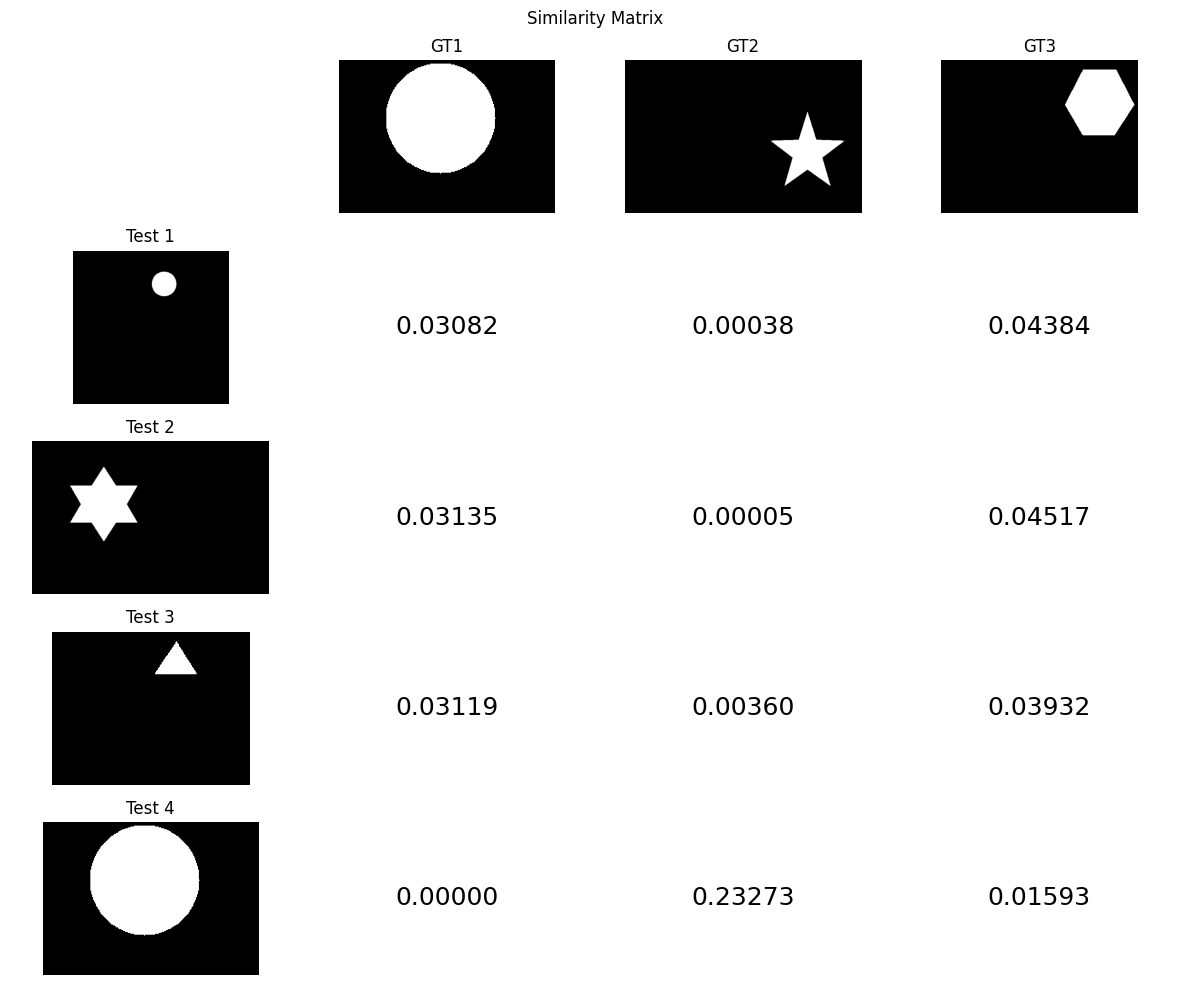

In [33]:
fig, axes = plt.subplots(len(test_images) + 1, len(train_images) + 1, figsize=(12, 10))
rows = len(test_images) + 1
cols = len(train_images) + 1

for ax in axes.flat:
    ax.axis('off')

for j, train_img in enumerate(train_images):
    ax = axes[0, j + 1]
    ax.imshow(train_img, cmap='gray')
    ax.set_title(f'GT{j+1}')
    ax.axis('off')

for i, test_img in enumerate(test_images):
    ax = axes[i + 1, 0]
    ax.imshow(test_img, cmap='gray')
    ax.set_title(f'Test {i+1}')
    ax.axis('off')

for i in range(len(test_images)):
    for j in range(len(train_images)):
        ax = axes[i + 1, j + 1]
        similarity_val = distances_matrix[i][j]
        ax.text(0.5, 0.5, f'{similarity_val:.5f}', ha='center', va='center', fontsize=18)
        ax.axis('off')

fig.suptitle('Similarity Matrix')
plt.tight_layout()
plt.show()